In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import strato_code.kpp4py as kpp

In [3]:
nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


In [4]:
df_range = pd.read_csv('strato_range.csv', index_col=0)
df_range.head(10)

,min,max
CH3,3.685817e-06,3.234628e+00
Cl2,6.685439e+03,1.245632e+05
Cl2O2,2.478591e+03,2.227402e+04
ClOO,3.769876e-04,2.320970e+02
OClO,5.689835e+03,2.060717e+06
BrCl,4.626044e+03,3.018356e+05
HOBr,3.703886e+05,8.473285e+05
BrONO2,7.216404e+03,5.382783e+05
HCO,3.274070e-08,2.464155e-02
CH3O,1.000000e-08,2.027971e+02


# Make training data

In [5]:
y0_list = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 35) )
y0_list.shape

(5000, 35)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 1.4 s, sys: 29.7 ms, total: 1.43 s
Wall time: 1.5 s


(5000, 34)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:34])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:34]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 35)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 0.97444866,  1.15243255,  0.767098  ,  1.03533635,  0.11408981,
        0.25442245,  1.2993885 ,  0.64317628,  0.89613306,  0.96202575,
        0.94513314,  0.85229202,  1.51083245,  1.29249694,  1.07815599,
        1.10927924,  0.97573787,  1.12121107,  1.11610697,  0.87838348,
        1.1826658 ,  0.88186295,  0.07183912,  0.83015733,  1.08828863,
        0.99047584,  1.0205667 ,  1.01666619,  0.97640752,  1.23522696,
        0.90021032,  0.91415716,  0.82171633,  1.05060348])

# Fit ANN

In [10]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [11]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(35, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 34)
)

In [23]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(2000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

100 0.008542492985725403
200 0.008022838272154331
300 0.007469960022717714
400 0.006922436412423849
500 0.00639393599703908
600 0.00585557846352458
700 0.005307015497237444
800 0.004757110495120287
900 0.004285749047994614
1000 0.003940889146178961


In [24]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 10.5 ms, sys: 1.53 ms, total: 12.1 ms
Wall time: 6.36 ms


In [25]:
r2_score(y_pred_numpy, Y_train)

0.92506627160283028

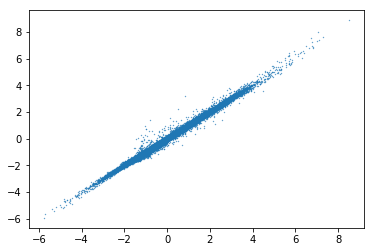

In [26]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)

# Test set

In [27]:
y0_test = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 35) )
y0_list.shape

(5000, 35)

In [28]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 1.31 s, sys: 11 ms, total: 1.32 s
Wall time: 1.33 s


In [29]:
X_test = np.append(normalizer.transform(y0_test[:,0:34]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [30]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 12.1 ms, sys: 1.94 ms, total: 14 ms
Wall time: 7.56 ms


In [31]:
r2_score(y_test_pred, Y_test)

0.89395739455268297

(-4, 4)

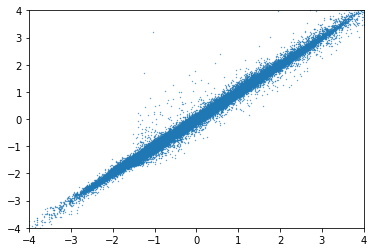

In [32]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-4,4)
plt.ylim(-4,4)

(-4, 4)

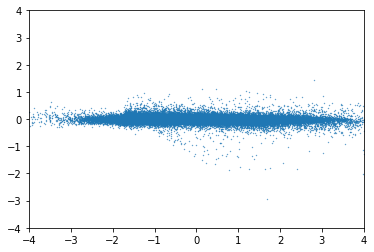

In [33]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-4,4)
plt.ylim(-4,4)